###**Data cleansing** 


1. Data validation
2. Handling of missing values
3. Detection of outliers
4. Handling of duplicates
5. Data transformation
6. Data normalization
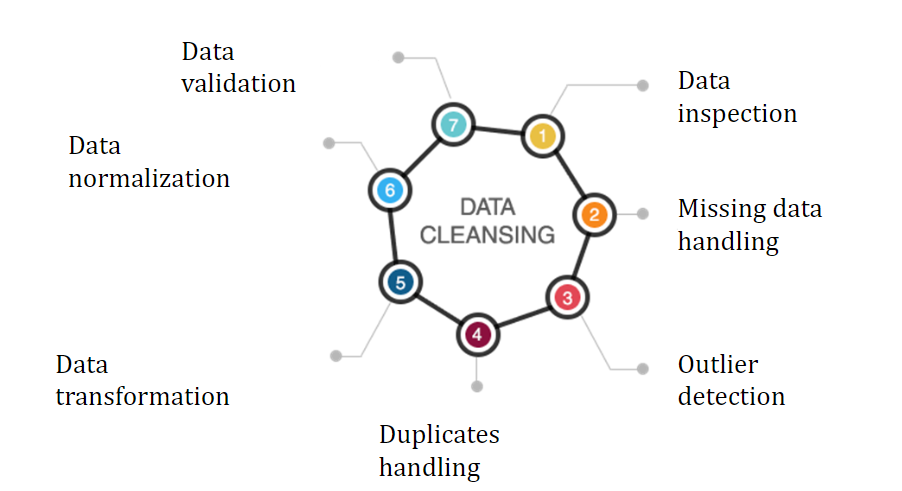


In [116]:
import pandas as pd
import numpy as np
import requests
import re
from statistics import mean, median
import seaborn as sns
import plotly.express as px
import pubchempy as pcp
import matplotlib.pyplot as plt

In [ ]:
!pip install crossref_commons

In [ ]:
!pip install pubchempy

In [4]:
# нужно добавить файл с датасетом во вкладке файлы слева в боковом меню
data = pd.read_csv('9.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     5000 non-null   object 
 1   Date                    4586 non-null   object 
 2   Journal                 4586 non-null   object 
 3   Title                   4586 non-null   object 
 4   Name                    4995 non-null   object 
 5   measurement_error       5000 non-null   float64
 6   measurement_wavelength  610 non-null    object 
 7   measurement_method      5000 non-null   object 
 8   normalised_name         2947 non-null   object 
 9   raw_value               5000 non-null   object 
 10  specifier               5000 non-null   object 
dtypes: float64(1), object(10)
memory usage: 429.8+ KB


# Missing data handling

In [6]:
#проверяем, какие параметры известны для тех, объектов, где пропуски в колонке с названием. 
#это все органика, для которых известны SMILES, так что сможем получить название исходя из них
data[data['Name'].isna()]

,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,normalised_name,raw_value,specifier
8,10.1016/j.molliq.2011.03.008,3/23/2011,Journal of Molecular Liquids,GROUNDEXCITEDSTATEDIPOLEMOMENTSDANSYLAMIDESOLV...,NaN,0.0,NaN,el_cde_tables,Cc1ccccc1,1.4969,n
1400,10.1039/C7RA01705G,5/3/2017,RSC Advances,Effect of solvent polarity on the photophysica...,NaN,0.0,NaN,rsc_cde_tables,Cc1ccc(C)cc1,1.495,n
2952,10.1039/B211838F,3/4/2003,Photochemical & Photobiological Sciences,Singlet excited state dipole moments of dual f...,NaN,0.0,NaN,rsc_cde_tables,CCOC(C)=O,1.37,n
3509,10.1016/j.fluid.2013.10.022,10/22/2013,Fluid Phase Equilibria,SOLUBILITYTIELINEDATAFORAQUEOUSSOLUTIONSBUTYRI...,NaN,0.0,NaN,el_mylogic,CCCC(O)=O,1.3977,nD
4474,10.1016/j.molliq.2011.09.018,10/11/2011,Journal of Molecular Liquids,MOLECULARINTERACTIONSSTRUCTURALEFFECTSMIXINGPE...,NaN,0.0,NaN,el_cde_tables,CCCCCO,1.423,nD


In [7]:
#проверяем, какие методы измерения дали пропуски в графах Date/Journal/Title, оказывается, что они все относятся к группам rsc_mylogic и snowball 
data[data.Date.isna()]['measurement_method'].value_counts()

snowball       315
rsc_mylogic     99
Name: measurement_method, dtype: int64

Проанализируем содержимое колонок: \
1) **DOI** - нет пропущенных значений, но есть некорректные объекты, где в DOI попало еще название журнала или дата, надо убрать, т.к. корректный DOI может быть полезен для заполнения пропусков в других колонках.\
2) **Date/Journal/Title** - можно добавить исходя из DOI (после его коррекции), который известен для всех объектов. \
3) **Name** - всего 5 пропущенных значений, для которых известны значения в колонке 'normalised_name, исходя из них заполним пропуски. Пропуски только в категориях rsc_mylogic и snowball.  \
4) **measurement_error** - в датасете всего 302 ненулевых значения из 5000, колонка может быть полезна для оценки состоятельности значения raw_value, если погрешность измерения выше 10%, то будем удалять этот объект из датасета. Заполнить пропущенные значения в некоторых случаях будет возможно исходя из колонки raw_value. \
5) **measurement_wavelength** - заполнено всего 610 значений из 5000, однако, для некоторых из них информация о длине волны содержится в колонке specifier, а также есть стандартные длины волн, на которых измеряют refractive index, они перечислены в таблице ниже. В колонке specifier будем искать буквенные обозначения для них и посмотрим, сколько получится заполнить.   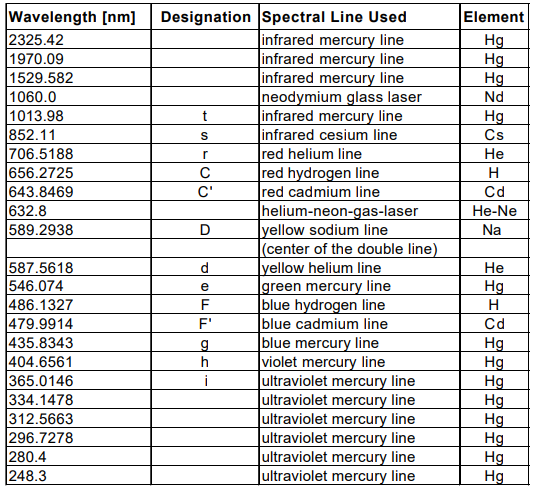 \
6) **measurement_method** - изучив несколько первойсточников можно сделать вывод, что первая часть кодировки - это информация об издательстве : Elsevier (el), Royal Society of Chemistry (rsc), Springer (springer)), а вторая - это информация о том, в каком виде была представлена информация в статье: значение RI взято из текста (cde_text), значение взято из таблицы (cde_table), значение взято из статьи, где определение RI для данного вещества не являлось конечной целью, например, исследовалась смесь его с другим веществом (mylogic), значение приведено в обзорной части или в разделе методы или просто не относится к приведенным выше категориям (snowball) \
7) **normalised_name** - для некоторых органических соединений в этой колонке приведены SMILES, для неорганики-формулы в виде списка элементов. Для заполнения пропусков в этой колонке используем функцию поиска SMILES по названию в БД pubchem и функцию по заполнению пропусков значениями для аналогичных веществ. Оставшиеся пропуски - это по большей части полимеры и неорганика - вторую будем заполнять через materials project. \
8) **raw_value** - все значения известны, но записаны в строковом формате и некоторые с погрешностью или в виде интервала. Здесь будем извлекать число, если дан интервал - то находить среднее и ошибку записывать в measurement_error, усли с погрешностью, то извлекать число и погрешность записывать в measurement_error. \
9) **specifier** - содержит информацию об обозначениях для RI в статье. \

### Заполняем пропуски в 'measurement_wavelength'

In [8]:
# функция, которая заполняет колонку "measurement_wavelength" значениями, которые указаны в колонке 'specifier', а также создает колонку с 
def get_wavelength(row):
  if pd.notna(row['measurement_wavelength']):
    num = re.findall(r'[+]?\d*\.?\d+|\d+', row['measurement_wavelength'])
    if 'μm'in row['measurement_wavelength']:
      return float(num[0])*1000
    else: 
      return float(num[0])
  else:
    if re.search(r'\s*n*[D]', row['specifier']):
      return 589
    elif re.search(r'[\s(]n.*d', row['specifier']):
      return 588
    elif re.search(r'[\s(]n.*[fF]', row['specifier']):
      return 486
    elif re.search(r'[\s(]n.*g', row['specifier']):
      return 436
    elif re.search(r'[\s(]n.*e', row['specifier']):
      return 546
    num = re.findall(r'[+]?\d*\.?\d+|\d+', row['specifier'])
    if len(num)!=0:
      if 'nm' in row['specifier']:
        return float(num[0])
      elif 'μm' in row['specifier'] or 'μ  m'in row['specifier']:
        return float(num[0])*1000
      elif ('Å' in row['specifier']) or ('Å' in row['specifier']):
        return float(num[0])/10
  

In [9]:
#создаем новую колонку, куда копируем имеющиеся значения 'measurement_wavelength' и дозаполняем пропуски
data['wavelength_added'] = data.apply(lambda row: get_wavelength(row), axis=1)

### Переводим строковые значения 'raw_value' в тип float и заполняем пропуски в колонку 'measurement_error'

In [10]:
#функция, которая превращает значение в колонке raw_value в численные
def get_float(row):
  values = re.findall(r"[+]?\d*\.?\d+|\d+", row['raw_value'])
  values = [float(x) for x in values]
  if (len(values) == 1):
    return values[0], 0
  elif values[0] > values[1]:
    if pd.isna(row['measurement_error']):
      return values[0], values[1]
    else:
      return values[0], row['measurement_error']
  elif values[0] < values[1]:
    if pd.isna(row['measurement_error']):
      return mean(values), (values[1] - values[0])/2
    else:
      return mean(values), row['measurement_error']

In [11]:
#создаем новую колонку, куда копируем имеющиеся значения RI и дозаполняем пропуски в measurement_error
data[['RI', 'measurement_error']] = data.apply(lambda row: get_float(row), axis=1, result_type="expand")

### Заполняем 5 пропусков в колонке 'Name'

In [12]:
def fill_name(row):
  if pd.isna(row['Name']) or ('Request' in row['Name']):
    path1 = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/"
    path2 = "/property/IUPACName/txt"
    url = path1+str(row['normalised_name'])+path2
    res = requests.get(url)
    return res.text[:-1]
  else:
    return row['Name']

In [13]:
data['Name'] = data.apply(lambda row:fill_name(row), axis=1)

### Коррекция DOI и заполнение пропусков в Date/Journal/Title

In [14]:
def fix_doi(row):
  if re.search(r"\d+[a-zA-Z]{3,}", row['DOI']):
    res = re.search(r"""\b(10[.][0-9]{4,}(?:[.][0-9]+)*/(?:(?!["&\'<>^_])\S)+\d)""", row['DOI']).group(0)
  elif re.search(r"\d+-X", row['DOI']):
    res = re.search(r"""\b(10[.][0-9]{4,}(?:[.][0-9]+)*/(?:(?!["&\'<>^_])\S)+-X)""", row['DOI']).group(0)
  else:
    res = re.search(r"""\b(10[.][0-9]{4,}(?:[.][0-9]+)*/(?:(?!["&\'<>^_])\S)+)""", row['DOI']).group(0)
  return res


In [15]:
data['DOI_alt'] = data.apply(lambda row:fix_doi(row), axis=1)

### Заполнение Journal/Title/Date по DOI для 414 пропусков

In [16]:
#функция, которая возвращает данные о названии, журнале, дате выпуска и издательстве.
import crossref_commons.retrieval
from datetime import date
def fill_article_info(row):
  
  if pd.isna(row['Title']):
    doi = row['DOI_alt']
    try:
      ans = crossref_commons.retrieval.get_publication_as_json(doi)
      dt = date.fromtimestamp(ans['created']['timestamp']/1000).strftime("%-m/%-d/%Y")
      tt = ''.join(ans['title'])
      pb = ans['publisher']
      jr = ''.join(ans['short-container-title'])
      return dt, tt, jr, pb

    except ValueError:
      return None
  else:
    return row['Date'], row['Title'], row['Journal'], None
   


In [17]:
#заполняем пропуски в датасете и добавляем новую колонку 'Publisher'
data[['Date','Title','Journal','Publisher']] = data.apply(lambda row: fill_article_info(row), axis=1, result_type="expand")


In [18]:
#в этих колонках осталось 5 пропусков, проверим эти DOI вручную
data[data.Date.isna()]

,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,normalised_name,raw_value,specifier,wavelength_added,RI,DOI_alt,Publisher
389,10.1118/1.2839,None,None,None,SiO2,0.0,NaN,snowball,"[['O', 2.0], ['Si', 1.0]]",1.46,n,NaN,1.460000,10.1118/1.2839,None
1887,10.1038/ncomms8,None,None,None,MMF,0.0,NaN,snowball,COc1c(C)c2COC(=O)c2c(O)c1C\C=C(C)\CCC(=O)OCCN3...,1.362,RI,NaN,1.362000,10.1038/ncomms8,None
2026,10.1016/j.mee.2004.03.068Microelectronic Engin...,None,None,None,glycerol,0.0,NaN,snowball,NaN,1.47,n,NaN,1.470000,10.1016/j.mee.2004.03.068,None
2393,10.1016/j.jpowsour.2010.07.,None,None,None,silicon,0.0,NaN,snowball,NaN,4.211549,refractive indices,NaN,4.211549,10.1016/j.jpowsour.2010.07.,None
3425,10.14356/kona.2017,None,None,None,SiO2,0.0,NaN,snowball,"[['O', 2.0], ['Si', 1.0]]",1.47,n,NaN,1.470000,10.14356/kona.2017,None


In [19]:
#вручную заполним один пропуск, оставшиеся 4 значения DOI находятся вручную по статьям и их надо будет удалить из датасета
data.loc[data.DOI_alt == '10.1016/j.mee.2004.03.068', ['Date','Title','Journal','Publisher']] = ['04/15/2004', 'On-chip optical components and microfluidic systems', 'Microelectronic Engineering', 'Elsevier BV']

### Разобьем колонку measurement_method на две - Method и Publisher

In [20]:
data['measurement_method'].value_counts()

el_mylogic            2121
el_cde_tables         1508
el_cde_text            389
snowball               315
rsc_cde_text           250
rsc_cde_tables         229
rsc_mylogic             99
springer_cde_text       62
springer_cde_table      27
Name: measurement_method, dtype: int64

In [21]:
def publisher_method_add(row):
  publisher_dict = {'el': 'Elsevier BV', 'rsc' : 'Royal Society of Chemistry (RSC)', 'springer': 'Springer Science and Business Media LLC'}
  methods_list = [r'cde_table', r'cde_text', r'mylogic', r'snowball']
  meth, publ = None, None
  for i in methods_list:
    try:
      meth = re.search(i, row['measurement_method']).group(0)
    except AttributeError:
      continue
  if pd.isna(row['Publisher']):
    for j in publisher_dict.keys():
      try:
        publ = publisher_dict[re.search(j, row['measurement_method']).group(0)]
      except AttributeError:
        continue
    return meth, publ
  else:
    return meth, row['Publisher']

In [22]:
data[['Method','Publisher']] = data.apply(lambda row: publisher_method_add(row), axis=1, result_type="expand")

### Убираем лишние колонки из датасета

In [24]:
df_1_step = data.drop(['measurement_wavelength', 'measurement_method', 'raw_value', 'specifier', 'DOI'], axis = 1).dropna(subset = ['Title'])
df_1_step.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4996 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               4996 non-null   object 
 1   Journal            4996 non-null   object 
 2   Title              4996 non-null   object 
 3   Name               4996 non-null   object 
 4   measurement_error  4996 non-null   float64
 5   normalised_name    2944 non-null   object 
 6   wavelength_added   1322 non-null   float64
 7   RI                 4996 non-null   float64
 8   DOI_alt            4996 non-null   object 
 9   Publisher          4996 non-null   object 
 10  Method             4996 non-null   object 
dtypes: float64(3), object(8)
memory usage: 468.4+ KB


In [ ]:
#используем колонку с данными о measurement_error, чтобы убрать значения, которым нельзя доверять (ошибка больше 10%)
to_drop_by_error = df_1_step[(df_1_step['measurement_error']/df_1_step['RI']) > 0.1].index
df_1 = df_1_step.drop(index = to_drop_by_error)
df_1

# Outliers detection

### Visualization




/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='RI', ylabel='wavelength_added'>

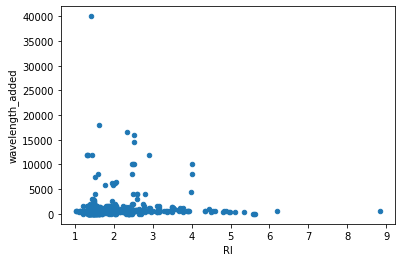

In [26]:
df_1_step.plot.scatter(x = 'RI', y = 'wavelength_added')
#видим тут два очевидных выброса

In [ ]:
df_1 = df_1[((df_1['wavelength_added']<20000) | (df_1['wavelength_added'].isna())) & (df_1['RI']<7)]
df_1

<Axes: ylabel='RI'>

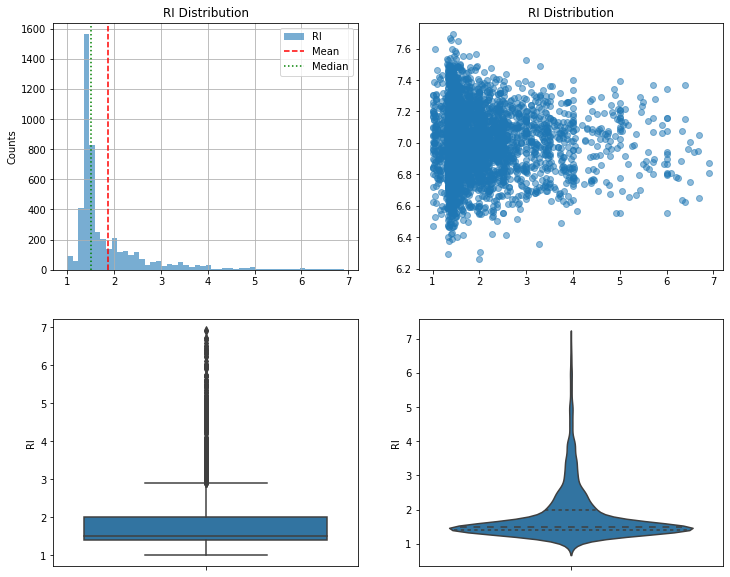

In [28]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
df_1['RI'].hist(bins=50, label='RI', alpha=0.6)
plt.axvline(np.mean(df_1['RI']), ls='--', c='r', label="Mean")
plt.axvline(np.median(df_1['RI']), ls=':', c='g', label="Median")
plt.ylabel("Counts")
plt.title("RI Distribution")
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(df_1['RI'], np.random.normal(7, 0.2, size=df_1.shape[0]), alpha=0.5)
plt.title("RI Distribution")

plt.subplot(2, 2, 3)
sns.boxplot(y="RI", data=df_1)

plt.subplot(2, 2, 4)
sns.violinplot(y="RI", data=df_1, inner="quartile", bw=0.2)

Распределение не является нормальным, если смотреть по boxplot - имеет выбросы.

In [ ]:
#измерения показателя преломления делаются на стандартной величине, так что заполним пропуски в колонке с длиной волны медианой.
df_1['wavelength_added'] = df_1['wavelength_added'].fillna(df_1['wavelength_added'].median())

Методы, включающие стандартное отклонение и z-показатели, можно использовать только тогда, когда набор данных или объект, который вы изучаете, подчиняется нормальному распределению. В нашем случае нет нормального распределения, поэтому нам эти методы не подходят.

In [37]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4857 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               4857 non-null   object 
 1   Journal            4857 non-null   object 
 2   Title              4857 non-null   object 
 3   Name               4857 non-null   object 
 4   measurement_error  4857 non-null   float64
 5   normalised_name    2871 non-null   object 
 6   wavelength_added   4857 non-null   float64
 7   RI                 4857 non-null   float64
 8   DOI_alt            4857 non-null   object 
 9   Publisher          4857 non-null   object 
 10  Method             4857 non-null   object 
dtypes: float64(3), object(8)
memory usage: 455.3+ KB


### Clustering for outliers detection

In [38]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_1[['RI', 'wavelength_added']])
distances, indices = nbrs.kneighbors(df_1[['RI', 'wavelength_added']])


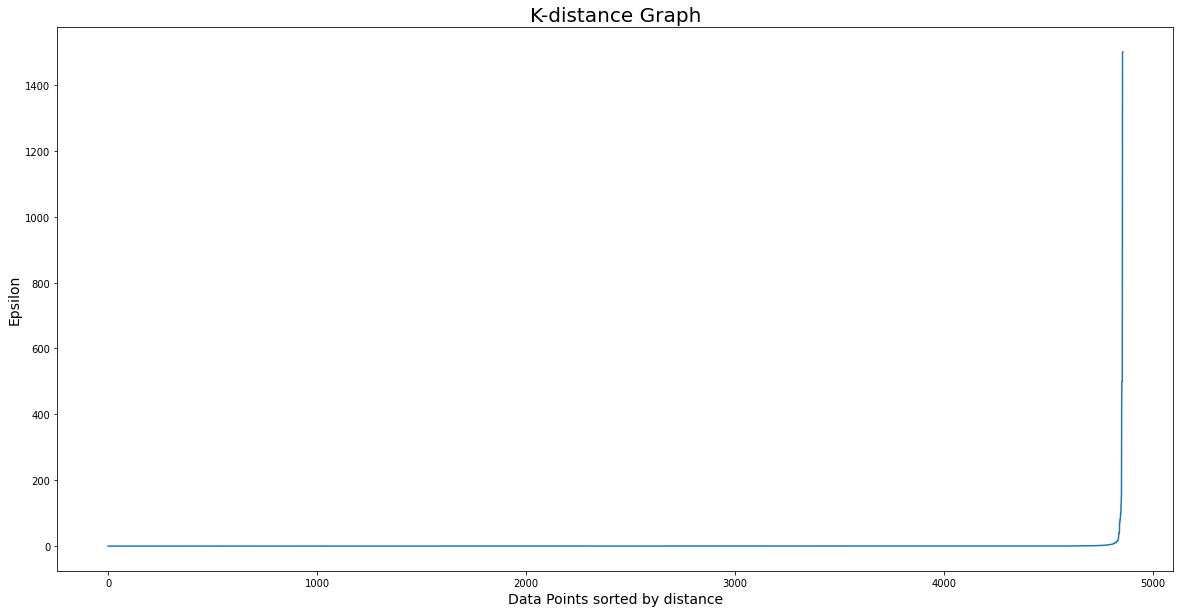

In [39]:
# Построим K-distance график для того, чтобы узнать, какое значение параметра расстояния надо брать для алгоритма DBSCAN
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

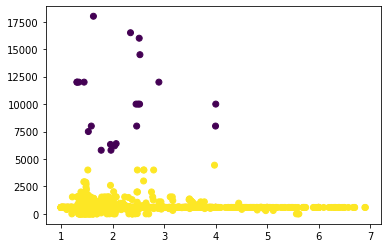

In [40]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps = 1200, min_samples = 10).fit(df_1[['RI', 'wavelength_added']])
dbscan=DBSCAN()
dbscan.fit(df_1[['RI', 'wavelength_added']])
colors = model.labels_
plt.scatter(df_1['RI'], df_1['wavelength_added'], c = colors)
#Видим, что измерения с длиной волны более 5000 нм алгоритм выделяет в кластер шума, поэтому нам необходимо избавиться от этих выбросов, однако из-за разных размерностей мы не можем судить о выбросах в колонке RI и о нижней границе в wavelength_added

In [41]:
#удалим выбросы, которые определили на предыдущем шаге из датасета
df_2 = df_1[model.labels_ != -1]
df_2

,Date,Journal,Title,Name,measurement_error,normalised_name,wavelength_added,RI,DOI_alt,Publisher,Method
0,6/9/2015,Journal of Cleaner Production,AREVIEWPROGRESSINDYEINGECOFRIENDLYALIPHATICPOL...,Nylon 6,0.0,NaN,589.0,1.52000,10.1016/j.jclepro.2015.05.126,Elsevier BV,cde_table
1,5/25/2011,Physical Chemistry Chemical Physics,Kirkwood correlation factors in liquid mixture...,Triglyme,0.0,COCCOCCOCCOC,589.0,1.42112,10.1039/C1CP20142E,Royal Society of Chemistry (RSC),cde_table
2,9/13/1999,Journal of Alloys and Compounds,GROWTHOPTICALPROPERTIESREDOPEDBULKFIBERSINGLEC...,YVO4,0.0,"[['O', 4.0], ['V', 1.0], ['Y', 1.0]]",589.0,2.16800,10.1016/S0925-8388(98)00420-4,Elsevier BV,cde_table
4,3/4/1999,Colloids and Surfaces A: Physicochemical and E...,ADSORPTIONOILSURFACTANTMONOLAYERSSTRUCTUREMIXE...,Toluene,0.0,NaN,589.0,1.49400,10.1016/S0927-7757(98)00782-1,Elsevier BV,cde_table
5,8/5/2004,Materials Science and Engineering: B,Fabrication of PECVD-silicon oxynitride-based ...,silicon dioxide,0.0,NaN,589.0,1.46000,10.1016/j.mseb.2004.05.037,Elsevier BV,snowball
...,...,...,...,...,...,...,...,...,...,...,...
4995,6/11/2010,Journal of Photochemistry and Photobiology A: ...,TIMEDOMAINEVALUATIONDRUGSOLVENTINTERACTIONSPHO...,Tetrahydrofuran,0.0,C1CCOC1,589.0,1.40700,10.1016/j.jphotochem.2010.06.004,Elsevier BV,cde_table
4996,6/17/2015,Phys. Chem. Chem. Phys.,Transformation of photophysical properties fro...,"1,4-Dioxane",0.0,C1COCCO1,589.0,1.42030,10.1039/C5CP02762D,Royal Society of Chemistry (RSC),mylogic
4997,4/13/2017,Vibrational Spectroscopy,IMPROVEMENTSTIO2CATALYZEDAGNPSBASEDSERSSUBSTRA...,TiO2,0.0,"[['O', 2.0], ['Ti', 1.0]]",589.0,1.63000,10.1016/j.vibspec.2017.03.005,Elsevier BV,cde_text
4998,9/12/2001,Journal of Photochemistry and Photobiology A: ...,PHOTOPHYSICALPROPERTIES25DIPHENYLTHIAZOLO54DTH...,Chloroform,0.0,ClC(Cl)Cl,357.2,1.44760,10.1016/S1010-6030(01)00520-2,Elsevier BV,mylogic


### Percentile for outliers detection

In [43]:
#используем метод процентилей для удалений необычно низких и необычно высоких значений для RI и measurement_wavelength
lower_limit, upper_limit = np.percentile(a=df_2['RI'],q=[1,99])
df_2_1 = df_2[(df_2['RI']>lower_limit) & (df_2['RI']<upper_limit)]
lower_limit, upper_limit = np.percentile(a=df_1['wavelength_added'],q=[1,99])
df_2_2 = df_2_1[(df_2_1['wavelength_added']>lower_limit) & (df_2_1['wavelength_added']<upper_limit)]
df_2_2.describe()


,measurement_error,wavelength_added,RI
count,4664.000000,4664.000000,4664.000000
mean,0.002319,595.173111,1.825105
std,0.018230,106.805894,0.725272
min,0.000000,14.000000,1.053000
25%,0.000000,589.000000,1.408925
50%,0.000000,589.000000,1.498000
75%,0.000000,589.000000,1.990475
max,0.440000,1571.500000,5.432000


### Заполним пропуски в колонке normalised_name
Для этого сначала для всех соединений из списка находим SMILES в базе данных PubChem, потом для оставшихся ищем при помощи pubchempy

In [45]:
#функция, которая берет Canonical Smiles из базы данных PubChem
def fill_with_SMILES(row):
  path1 = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/"
  path2 = "/property/CanonicalSMILES/txt"
  url = path1+str(row['Name'])+path2
  res = requests.get(url)
  if res.status_code == 200:
    return res.text[:-1]
  else:
    while res.status_code == 503:
      url = path1+str(row['Name'])+path2
      res = requests.get(url)
      if res.status_code != 503:
        return res.text[:-1]
    if res.status_code != 404:
      return None

In [ ]:
#долго выполняется (минут 20), тк выполняет поиск по базе данных для каждого соединения
df_2_2['SMILES'] = df_2_2.apply(lambda row: fill_with_SMILES(row), axis=1)

In [49]:
def fill_smiles_for_inorg(row):
  if pd.isna(row['SMILES']):
    if re.match(r'((H|He|Li|Be|B|C|N|O|F|Ne|Na|Mg|Al|Si|P|S|Cl|Ar|K|Ca|Sc|Ti|V|Cr|Mn|Fe|Co|Ni|Cu|Zn|Ga|Ge|As|Se|Br|Kr|Rb|Sr|Y|Zr|Nb|Mo|Tc|Ru|Rh|Pd|Ag|Cd|In|Sn|Sb|Te|I|Xe|Cs|Ba|La|Ce|Pr|Nd|Pm|Sm|Eu|Gd|Tb|Dy|Ho|Er|Tm|Yb|Lu|Hf|Ta|W|Re|Os|Ir|Pt|Au|Hg|Tl|Pb|Bi|Po|At|Rn)[\d)(\.]*){1,5}\b', str(row['Name'])):
      try:
        return pcp.get_properties('CanonicalSMILES', row['Name'], 'formula')[0]['CanonicalSMILES']
      except:
        return 'Not Found'
    else: 
      return None
  else: 
    return row['SMILES']

In [ ]:
df_2_2['SMILES'] = df_2_2.apply(lambda row: fill_smiles_for_inorg(row), axis=1)

In [51]:
df_2_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4664 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               4664 non-null   object 
 1   Journal            4664 non-null   object 
 2   Title              4664 non-null   object 
 3   Name               4664 non-null   object 
 4   measurement_error  4664 non-null   float64
 5   normalised_name    2766 non-null   object 
 6   wavelength_added   4664 non-null   float64
 7   RI                 4664 non-null   float64
 8   DOI_alt            4664 non-null   object 
 9   Publisher          4664 non-null   object 
 10  Method             4664 non-null   object 
 11  SMILES             4161 non-null   object 
dtypes: float64(3), object(9)
memory usage: 473.7+ KB


In [52]:
df_2_2.to_csv('data_with_smiles.csv')

# Duplicates handling

In [91]:
df_2_3 =  df_2_2.drop_duplicates(keep='first', subset = ['SMILES', 'wavelength_added', 'RI'])
df_2_3

,Date,Journal,Title,Name,measurement_error,normalised_name,wavelength_added,RI,DOI_alt,Publisher,Method,SMILES
0,6/9/2015,Journal of Cleaner Production,AREVIEWPROGRESSINDYEINGECOFRIENDLYALIPHATICPOL...,Nylon 6,0.0,NaN,589.0,1.520000,10.1016/j.jclepro.2015.05.126,Elsevier BV,cde_table,None
1,5/25/2011,Physical Chemistry Chemical Physics,Kirkwood correlation factors in liquid mixture...,Triglyme,0.0,COCCOCCOCCOC,589.0,1.421120,10.1039/C1CP20142E,Royal Society of Chemistry (RSC),cde_table,COCCOCCOCCOC
2,9/13/1999,Journal of Alloys and Compounds,GROWTHOPTICALPROPERTIESREDOPEDBULKFIBERSINGLEC...,YVO4,0.0,"[['O', 4.0], ['V', 1.0], ['Y', 1.0]]",589.0,2.168000,10.1016/S0925-8388(98)00420-4,Elsevier BV,cde_table,[O-2].[O-2].[O-2].[O-2].[V].[Y+3]
4,3/4/1999,Colloids and Surfaces A: Physicochemical and E...,ADSORPTIONOILSURFACTANTMONOLAYERSSTRUCTUREMIXE...,Toluene,0.0,NaN,589.0,1.494000,10.1016/S0927-7757(98)00782-1,Elsevier BV,cde_table,CC1=CC=CC=C1
5,8/5/2004,Materials Science and Engineering: B,Fabrication of PECVD-silicon oxynitride-based ...,silicon dioxide,0.0,NaN,589.0,1.460000,10.1016/j.mseb.2004.05.037,Elsevier BV,snowball,O=[Si]=O
...,...,...,...,...,...,...,...,...,...,...,...,...
4991,7/30/2011,Thermochimica Acta,THERMOPHYSICALSTUDYNHEXANENHEPTANE1CHLOROPROPA...,n-Heptane,0.0,CCCCCCC,589.0,1.390333,10.1016/j.tca.2011.07.023,Elsevier BV,mylogic,CCCCCCC
4994,6/9/2015,RSC Adv.,Semitransparent polymer-based solar cells via ...,TiO2,0.0,NaN,26.0,1.640000,10.1039/C5RA05762K,Royal Society of Chemistry (RSC),mylogic,O=[Ti]=O
4996,6/17/2015,Phys. Chem. Chem. Phys.,Transformation of photophysical properties fro...,"1,4-Dioxane",0.0,C1COCCO1,589.0,1.420300,10.1039/C5CP02762D,Royal Society of Chemistry (RSC),mylogic,C1COCCO1
4997,4/13/2017,Vibrational Spectroscopy,IMPROVEMENTSTIO2CATALYZEDAGNPSBASEDSERSSUBSTRA...,TiO2,0.0,"[['O', 2.0], ['Ti', 1.0]]",589.0,1.630000,10.1016/j.vibspec.2017.03.005,Elsevier BV,cde_text,O=[Ti]=O


# Data transformation

In [128]:
#Frequency Encoding
#df_2_3['Publisher'].value_counts()/len(df_2_3['Publisher'])

Elsevier BV                                0.859903
Royal Society of Chemistry (RSC)           0.119968
Springer Science and Business Media LLC    0.020129
Name: Publisher, dtype: float64

In [ ]:
method_mapping = {'mylogic':0,'cde_table':1,'cde_text':2,'snowball':3}
publisher_mapping = {'Elsevier BV':0,'Royal Society of Chemistry (RSC)':1,'Springer Science and Business Media LLC':2}
df_2_3['Method_ord'] = df_2_3['Method'].map(method_mapping)
df_2_3['Publisher_ord'] = df_2_3['Publisher'].map(publisher_mapping)
df_2_3

## Оставим в датасете только интересующие нас колонки и уберем оставшиеся NaN значения



In [130]:
df_2_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3726 entries, 0 to 4998
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               3726 non-null   object 
 1   Journal            3726 non-null   object 
 2   Title              3726 non-null   object 
 3   Name               3726 non-null   object 
 4   measurement_error  3726 non-null   float64
 5   normalised_name    2193 non-null   object 
 6   wavelength_added   3726 non-null   float64
 7   RI                 3726 non-null   float64
 8   DOI_alt            3726 non-null   object 
 9   Publisher          3726 non-null   object 
 10  Method             3726 non-null   object 
 11  SMILES             3373 non-null   object 
 12  Method_ord         3726 non-null   int64  
 13  Publisher_ord      3726 non-null   int64  
dtypes: float64(3), int64(2), object(9)
memory usage: 436.6+ KB


In [131]:
df_2_3.columns

Index(['Date', 'Journal', 'Title', 'Name', 'measurement_error',
       'normalised_name', 'wavelength_added', 'RI', 'DOI_alt', 'Publisher',
       'Method', 'SMILES', 'Method_ord', 'Publisher_ord'],
      dtype='object')

In [135]:
df_2_4 = df_2_3[['Date', 'Journal', 'Title', 'Name', 'wavelength_added', 'RI', 'DOI_alt', 'SMILES', 'Method_ord', 'Publisher_ord']]
df_final = df_2_4[(df_2_4['SMILES'].notna())& (df_2_4['SMILES'] != 'Not Found')]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2973 entries, 1 to 4998
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              2973 non-null   object 
 1   Journal           2973 non-null   object 
 2   Title             2973 non-null   object 
 3   Name              2973 non-null   object 
 4   wavelength_added  2973 non-null   float64
 5   RI                2973 non-null   float64
 6   DOI_alt           2973 non-null   object 
 7   SMILES            2973 non-null   object 
 8   Method_ord        2973 non-null   int64  
 9   Publisher_ord     2973 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 255.5+ KB


In [136]:
df_final.to_csv('df_9_after_cleansing.csv')